## Exploratory Data Analysis

### Import Libraries

In [11]:
import io
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from PIL import Image

### Load and Verify Dataset

In [12]:
# Load HDF5 Data and Decode Images for Processing
hdf5_path = "../dataset/dataset.hdf5"

# Define the crop and sensor order as per the mapping
crop_order = [
    "BARLEY", 
    "CANOLA", 
    "CORN", 
    "MIXEDWOOD", 
    "OAT",
    "ORCHARD", 
    "PASTURE", 
    "POTATO", 
    "SOYBEAN", 
    "SPRING_WHEAT"
]
sensors = [
    "RGB", 
    "NDVI", 
    "NDVI45", 
    "OSAVI", 
    "PSRI", 
    "GNDVI"
]

# Function to decode an image stored as a variable-length uint8 array
def decode_image(uint8_array):
    if uint8_array.size == 0:
        return None
    # Convert the uint8 numpy array back to bytes
    img_bytes = uint8_array.tobytes()
    try:
        image = Image.open(io.BytesIO(img_bytes))
        image = image.convert("RGB")
        return image
    except Exception as e:
        print("Error decoding image:", e)
        return None

# Load data from HDF5 file
with h5py.File(hdf5_path, "r") as hf:
    print("Datasets available in the HDF5 file:")
    for key in hf.keys():
        print(f"{key}: {hf[key].shape}")
    
    # Number of records (assuming all metadata arrays have the same length)
    num_records = hf["POINT"].shape[0]
    print("\nTotal number of records:", num_records)
    
    record_idx = random.randint(0, num_records - 1)
    print(f"\nRandomly selected record index: {record_idx}")
    
    # Decode and print details for each sensor image in the random record
    for sensor in sensors:
        sensor_data = hf[sensor][record_idx]
        image = decode_image(sensor_data)
        if image is not None:
            print(f"{sensor}: decoded image shape = {image.size}, mode = {image.mode}")
        else:
            print(f"{sensor}: No image data or decoding failed.")

Datasets available in the HDF5 file:
CROP_TYPE: (22413,)
DATE: (22413,)
GNDVI: (22413,)
LABEL: (22413,)
NDVI: (22413,)
NDVI45: (22413,)
OSAVI: (22413,)
POINT: (22413,)
PSRI: (22413,)
REGION: (22413,)
RGB: (22413,)

Total number of records: 22413

Randomly selected record index: 5948
RGB: decoded image shape = (65, 65), mode = RGB
NDVI: decoded image shape = (65, 65), mode = RGB
NDVI45: decoded image shape = (65, 65), mode = RGB
OSAVI: decoded image shape = (65, 65), mode = RGB
PSRI: decoded image shape = (65, 65), mode = RGB
GNDVI: decoded image shape = (65, 65), mode = RGB


### Crop Types and Sensor Types

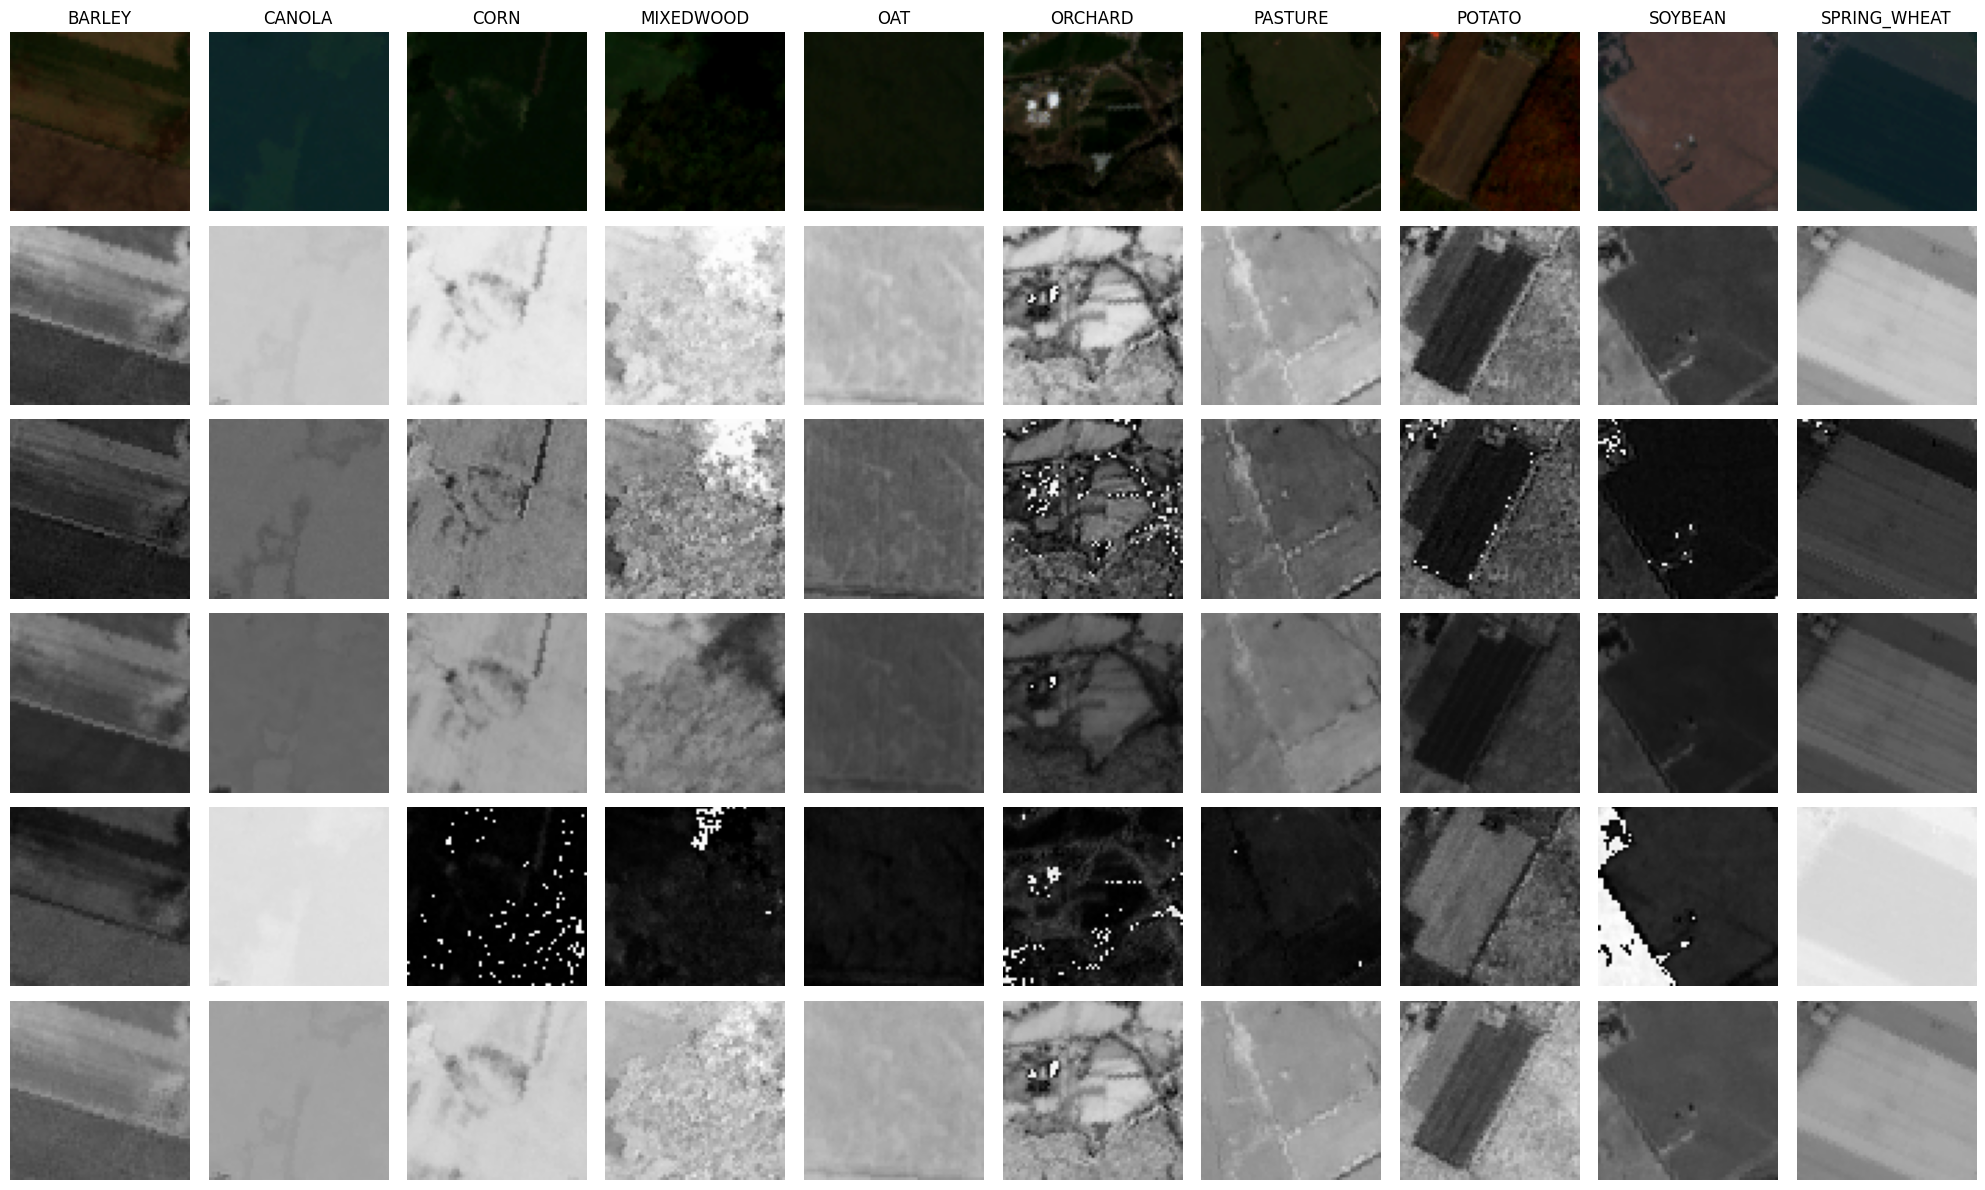

In [13]:
# Select one random sample for each crop type
selected_samples = {}  # key: crop type, value: record index

with h5py.File(hdf5_path, "r") as hf:
    crop_types = np.array(hf["CROP_TYPE"][:], dtype=str)
    
    # For each crop, choose one random sample if available
    for crop in crop_order:
        indices = np.where(crop_types == crop)[0]
        if len(indices) > 0:
            selected_samples[crop] = random.choice(indices)
        else:
            print(f"No samples found for crop: {crop}")

    # Create a grid: rows = sensor types, columns = crop types
    fig, axes = plt.subplots(nrows=len(sensors), ncols=len(crop_order), figsize=(20, 12))
    
    # Loop over each sensor (row) and each crop (column)
    for row, sensor in enumerate(sensors):
        for col, crop in enumerate(crop_order):
            ax = axes[row, col]
            ax.axis("off")
            # Get the record index for this crop type
            if crop in selected_samples:
                idx = selected_samples[crop]
                sensor_data = hf[sensor][idx]
                image = decode_image(sensor_data)
                if image is not None:
                    ax.imshow(image)
                else:
                    ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10)
            else:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10)
            # Set the crop label on the top row
            if row == 0:
                ax.set_title(crop, fontsize=12)
        # Label the sensor type on the left of each row
        axes[row, 0].set_ylabel(sensor, fontsize=12, rotation=90, labelpad=10, va="center")
    
    plt.tight_layout()
    plt.show()

### Crop Types over Seasons

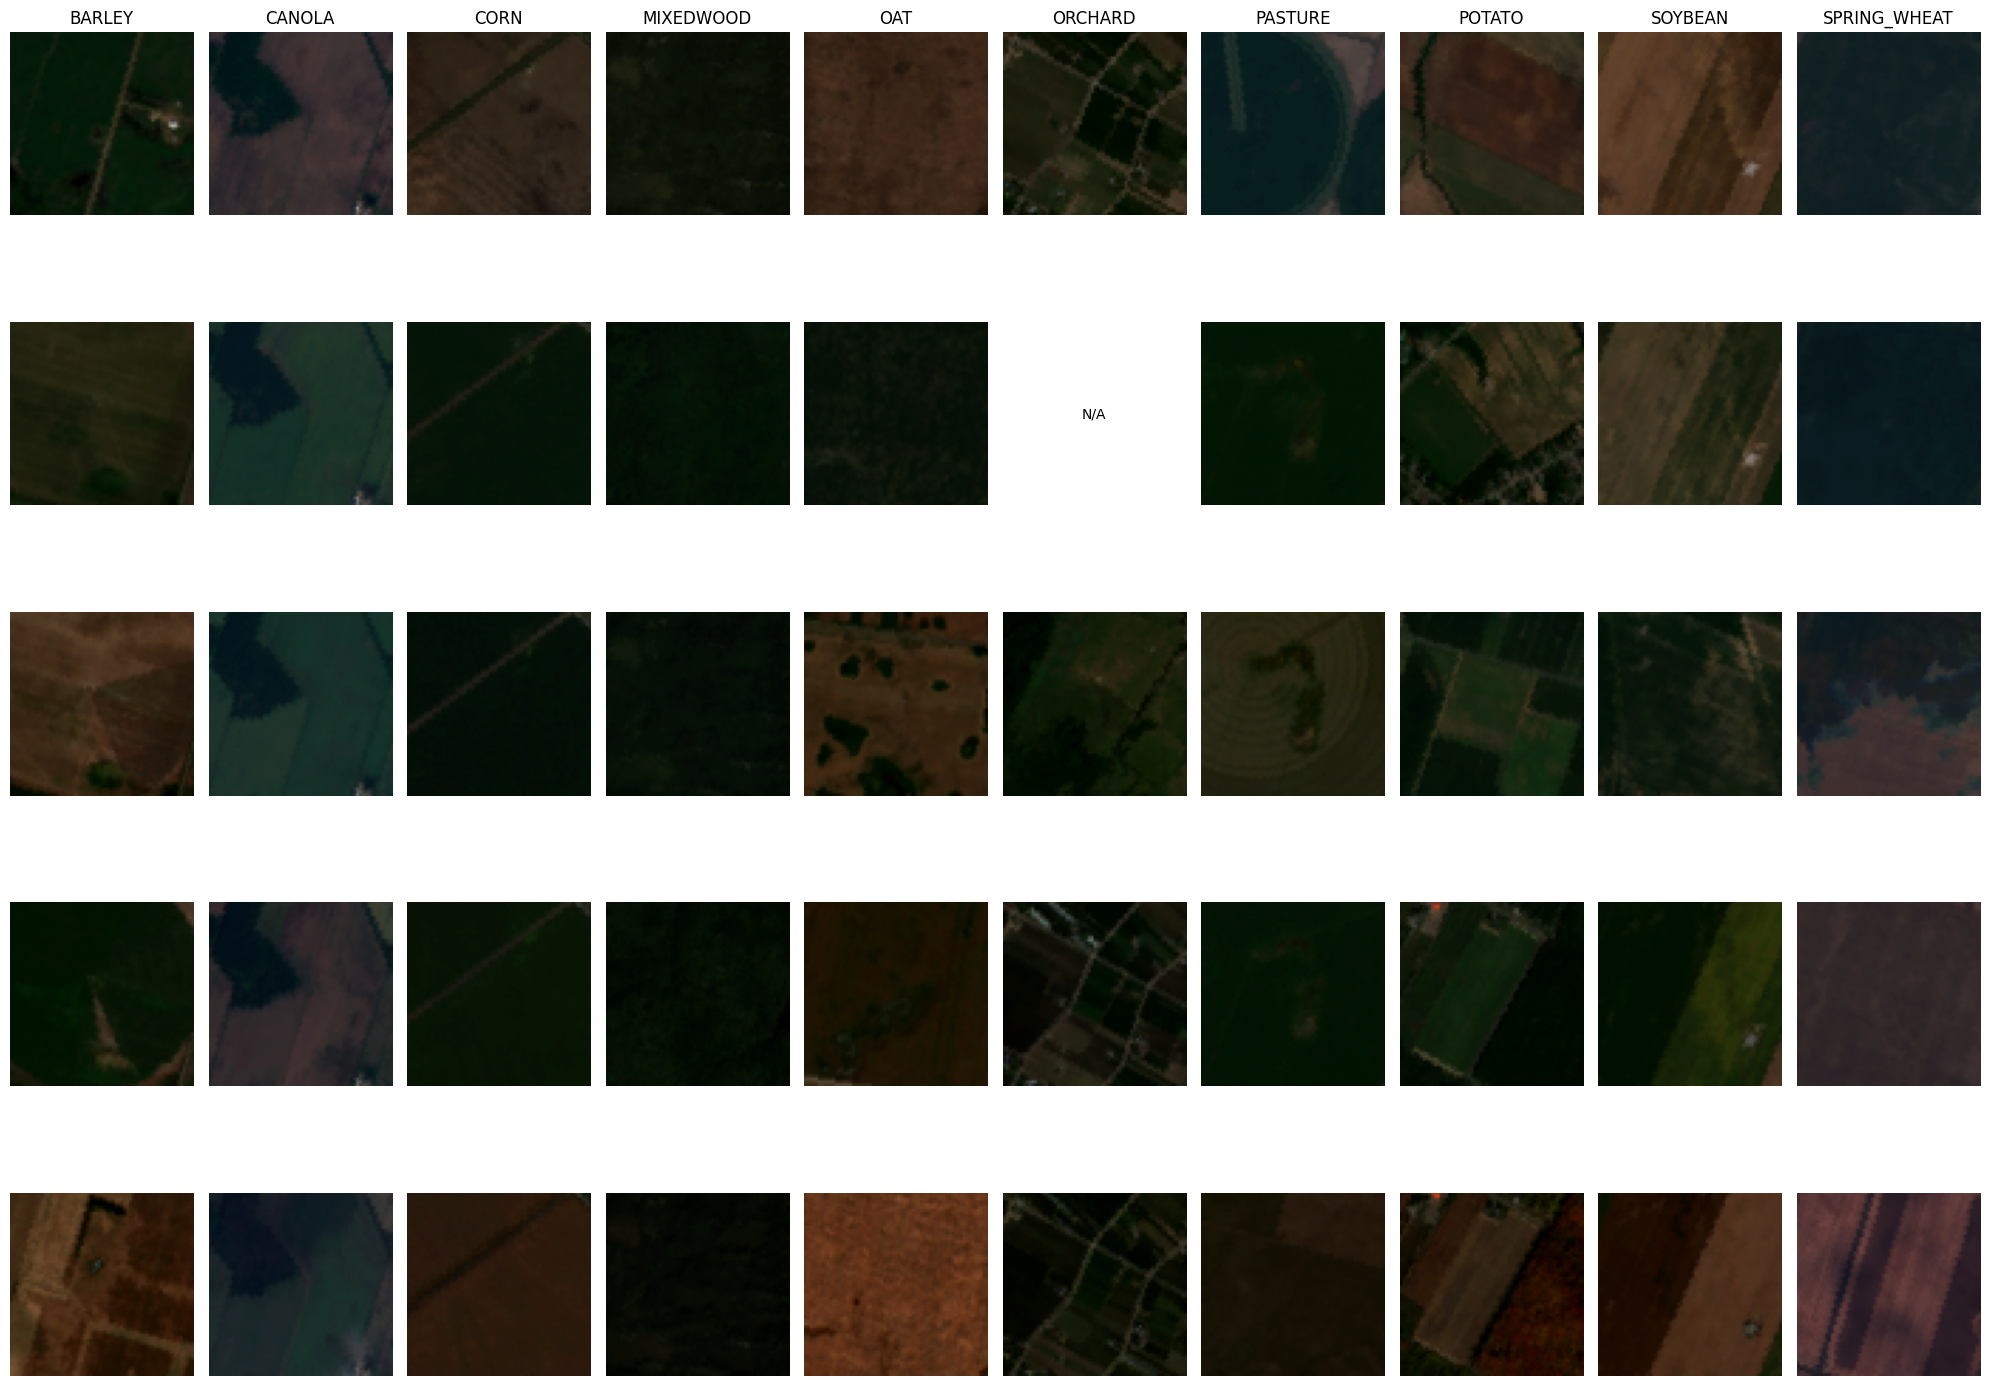

In [14]:
# Define the date range of interest
date_range = pd.date_range(start="2019-06-01", end="2019-10-31", freq='MS')
date_labels = date_range.strftime('%Y%m')

with h5py.File(hdf5_path, "r") as hf:
    # Extract relevant datasets
    crop_types = np.array(hf["CROP_TYPE"][:], dtype=str)
    dates = np.array(hf["DATE"][:], dtype=str)
    labels = np.array(hf["LABEL"][:], dtype=str)
    regions = np.array(hf["REGION"][:], dtype=str)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=len(date_labels), ncols=len(crop_order), figsize=(20, 15))
    
    # Loop over each crop type (column)
    for col, crop in enumerate(crop_order):
        # Find indices for the current crop type
        crop_indices = np.where(crop_types == crop)[0]
        
        # If no samples for this crop, skip
        if len(crop_indices) == 0:
            for row in range(len(date_labels)):
                ax = axes[row, col]
                ax.axis("off")
                if row == 0:
                    ax.set_title(crop, fontsize=12)
            continue
        
        # Randomly select one sample for this crop
        selected_idx = random.choice(crop_indices)
        selected_label = labels[selected_idx]
        selected_region = regions[selected_idx]
        
        # Loop over each date (row)
        for row, date_label in enumerate(date_labels):
            ax = axes[row, col]
            ax.axis("off")
            
            # Set crop type as title for the top row
            if row == 0:
                ax.set_title(crop, fontsize=12)
            
            # Set date as y-axis label for the first column
            if col == 0:
                ax.set_ylabel(date_label, fontsize=12, rotation=0, labelpad=50, va="center")
            
            # Construct the identifier for the current cell
            identifier = f"{selected_label}_{date_label}_{selected_region}_RGB"
            
            # Find the index matching the identifier
            matching_indices = [i for i in range(len(labels))
                                if labels[i] == selected_label and
                                   dates[i] == date_label and
                                   regions[i] == selected_region and
                                   crop_types[i] == crop]
            
            if matching_indices:
                idx = matching_indices[0]
                rgb_data = hf["RGB"][idx]
                image = decode_image(rgb_data)
                if image is not None:
                    ax.imshow(image)
                else:
                    ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10)
            else:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10)
    
    plt.tight_layout()
    plt.show()